In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
print("Person A: Loading datasets...")
df_train = pd.read_csv("train_FD001.txt", sep=" ", header=None)
df_test = pd.read_csv("test_FD001.txt", sep=" ", header=None)
df_rul = pd.read_csv("RUL_FD001.txt", sep=" ", header=None)
print("✓ Files loaded successfully!")

Person A: Loading datasets...
✓ Files loaded successfully!


In [5]:
df_train = df_train.iloc[:, :26]
df_test = df_test.iloc[:, :26]

# Set correct column names

columns = [
    "engine_id", "cycle",
    "setting_1", "setting_2", "setting_3",
    "s1","s2","s3","s4","s5","s6","s7","s8","s9","s10",
    "s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"
]

df_train.columns = columns
df_test.columns = columns

print("✓ Column names applied successfully!")

✓ Column names applied successfully!


In [6]:
# Check missing values
print("\nMissing values in training data:")
print(df_train.isnull().sum())


Missing values in training data:
engine_id    0
cycle        0
setting_1    0
setting_2    0
setting_3    0
s1           0
s2           0
s3           0
s4           0
s5           0
s6           0
s7           0
s8           0
s9           0
s10          0
s11          0
s12          0
s13          0
s14          0
s15          0
s16          0
s17          0
s18          0
s19          0
s20          0
s21          0
dtype: int64


In [7]:
# Compute Remaining Useful Life (RUL)
max_cycles = df_train.groupby("engine_id")["cycle"].max()
df_train["RUL"] = df_train.apply(
    lambda row: max_cycles[row["engine_id"]] - row["cycle"],
    axis=1
)

In [ ]:
# Scaling sensor values
sensor_cols = df_train.columns[5:26]
scaler = MinMaxScaler()
df_train[sensor_cols] = scaler.fit_transform(df_train[sensor_cols])
df_test[sensor_cols] = scaler.transform(df_test[sensor_cols])

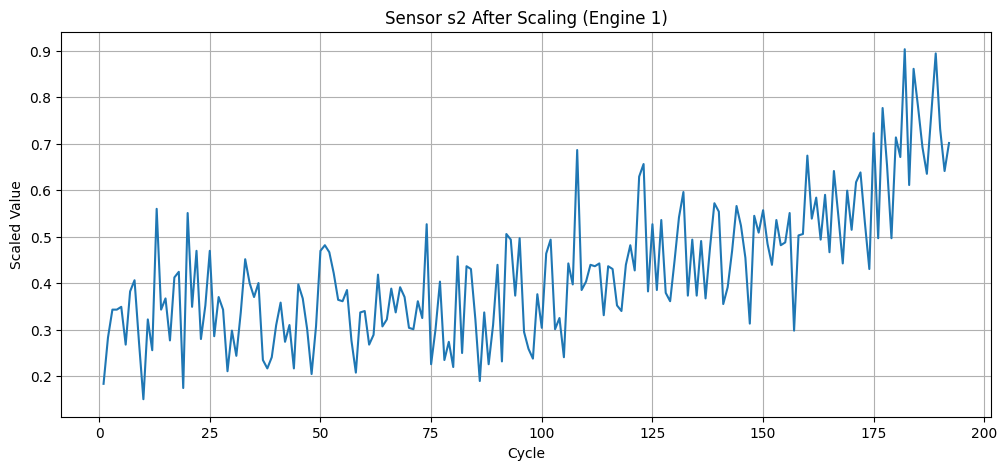

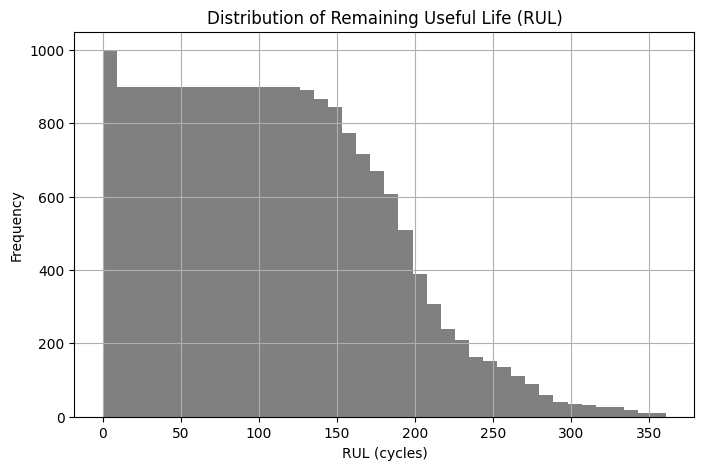

In [9]:
# Visualizations
engine_1 = df_train[df_train["engine_id"] == 1]

plt.figure(figsize=(12,5))
plt.plot(engine_1["cycle"], engine_1["s2"])
plt.title("Sensor s2 After Scaling (Engine 1)")
plt.xlabel("Cycle")
plt.ylabel("Scaled Value")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df_train["RUL"], bins=40, color="gray")
plt.title("Distribution of Remaining Useful Life (RUL)")
plt.xlabel("RUL (cycles)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [10]:
# Create sequences for LSTM

seq_length = 50
feature_cols = sensor_cols.tolist() + ["setting_1","setting_2","setting_3"]


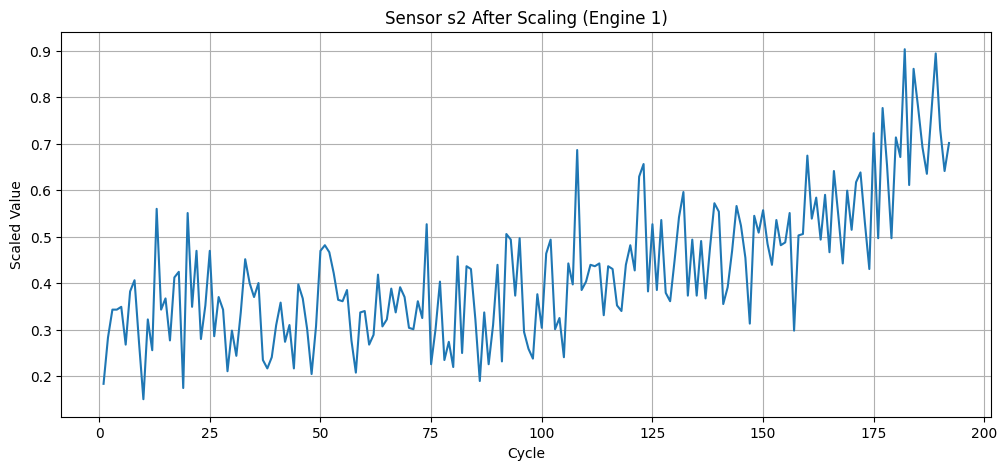

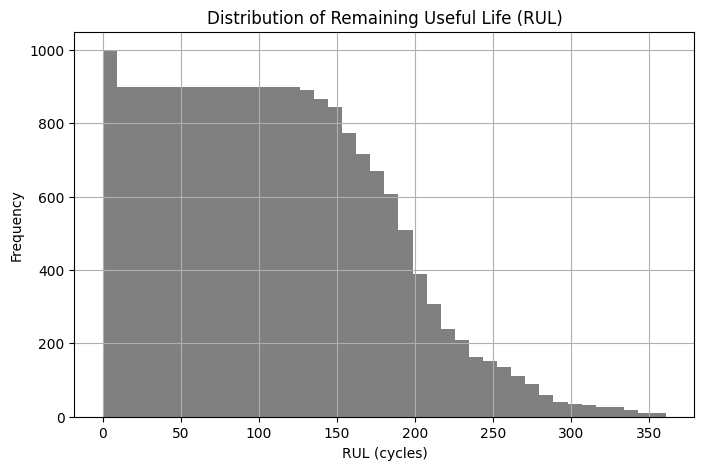

In [11]:
# Visualizations
engine_1 = df_train[df_train["engine_id"] == 1]

plt.figure(figsize=(12,5))
plt.plot(engine_1["cycle"], engine_1["s2"])
plt.title("Sensor s2 After Scaling (Engine 1)")
plt.xlabel("Cycle")
plt.ylabel("Scaled Value")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df_train["RUL"], bins=40, color="gray")
plt.title("Distribution of Remaining Useful Life (RUL)")
plt.xlabel("RUL (cycles)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [12]:
def create_sequences(df, seq_length):
    X, y = [], []
    for engine in df['engine_id'].unique():
        data_engine = df[df['engine_id']==engine]
        features = data_engine[feature_cols].values
        labels = data_engine['RUL'].values
        for i in range(len(data_engine)-seq_length):
            X.append(features[i:i+seq_length])
            y.append(labels[i+seq_length])
    return np.array(X), np.array(y)

In [13]:
X, y = create_sequences(df_train, seq_length)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (15631, 50, 24)
y shape: (15631,)


In [15]:
# LSTM Model Building & Training

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [16]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Build LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1))  # Output = RUL
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\Original\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,101 (195.71 KB)

 Trainable params: 50,101 (195.71 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 8398.0625 - val_loss: 7010.9658
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - loss: 6110.9780 - val_loss: 5456.0874
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - loss: 4900.9062 - val_loss: 4507.9717
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - loss: 4145.8003 - val_loss: 3907.1724
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 3691.7534 - val_loss: 3574.4717
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 3455.3145 - val_loss: 3408.6638
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 3341.8577 - val_loss: 3331.4998
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 3290.5659 - val_loss: 3297.7871
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - loss: 3270.5784 - val_loss: 3284.8938
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3324.3435

In [ ]:
# Plot training history
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Model Evaluation & Saving

from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
# Predict RUL
y_pred = model.predict(X_val)

In [ ]:
# Compute MSE and RMSE
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)


In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(y_val[:100], label='Actual RUL')
plt.plot(y_pred[:100], label='Predicted RUL')
plt.title("Predicted vs Actual RUL (First 100 samples)")
plt.xlabel("Samples")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Save final model
model.save("project_foresight_lstm.h5")
print("Model saved as project_foresight_lstm.h5")